# Searching for Cusp Bifurcations in the E2F-Rb Network

E2F transcription factors regulate the behavior of many genes important to cell proliferation. In turn, the Rb protein limits cell proliferation by suppressing the E2F transcription factor. In the majority of cancers, Rb is not activated. In this notebook, we study the continuation of dynamics in a reduced model of the E2F-Rb network. 

In [3]:
import DSGRN 
import DSGRN_utils
%run -i 'context.py'

import os
import sys
import math
import pickle

# DSGRN setup
We use a reduced version of the network model proposed in [1].

In [4]:
net_spec = """
Rb : (~CycE)(E2F)
E2F : (~Rb)(E2F)
CycE : (E2F)
"""

Now to construct the parameter graph from DSGRN.

In [5]:
network = DSGRN.Network(net_spec)
parameter_graph = DSGRN.ParameterGraph(network)
print('Parameter graph has size', parameter_graph.size())

Parameter graph has size 5400


Review the parameter graph and network.

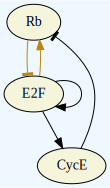

In [6]:
DSGRN.DrawGraph(network)

The package DSGRN_utils has a function StabilityQuery() which produces a dictionary encoding the stabilities of each parameter node. The keys of this dictionary are whole numbers, and the value for a fixed key is the list of parameter indices whose attractor lattice has that many atoms. For example, parameters exhibiting monostability are contained in the value at key 1, bistability at key 2, etc. For this size network the query takes a few minutes, so we'll load a copy that's already been computed instead.

In [7]:
# param_stability = DSGRN_utils.StabilityQuery(network)
# with open("E2F-RB_stability.pkl", "wb") as file:
#     pickle.dump(param_stability, file)

with open("E2F-RB_stability.pkl", "rb") as file:
    param_stability = pickle.load(file)
    
print("".join(["# of parameters with "+str(i)+"-stability: "+str(len(param_stability[i]))+"\n" 
               for i in param_stability.keys()]))

# of parameters with 1-stability: 3602
# of parameters with 2-stability: 1720
# of parameters with 3-stability: 78



# Determining the cusp bifurcations
To find cusp bifurcations for this network we'll look for loops in the parameter graph through bistable nodes where there is only one global section. We set up a bifurcation query object with the appropriate parameters to find them.

The BifurcationQuery class stores a graph (defined by a set of vertices and set of edges), a grading on the vertices of the graph, and a list of criteria for sheaf cohomology. When executed, the query returns a list of "matches". A match is the image of a graph embedding from the input graph to the parameter graph which respects the grading on the vertices, and satisfies the cohomology criteria. A cohomology criterion is encoded in the form of a predicate function, which must read the output of the sheaf_cohomology() method and return True or False. 

In our case, we only have one cohomology criteria, which is that the attractor sheaf built on the loop has only one global section. 

In [8]:
vertices = ['a','b','c','d'] #We're looking for sets of four parameter indices

edges = [('a','b'), ('b','c'), ('c','d'), ('a','d')] #which form a loop in the parameter graph.

match_grading = {1 : ['a','b','c'], 2 : ['d']} #Three of the indicies should be monostable, one bistable.

coho_criteria = [{
                  'predicate' : lambda sc : len(sc[0]) == 1, #Look for cases where there is only one global section.
                  'dim' : 1,
                  'clean_stalks' : True #Optional argument to prune unnecessary Morse sets from coarse graphs
                 }]

query = BifurcationQuery(parameter_graph, vertices, edges, param_stability, match_grading, coho_criteria)

Especially since there are three spatial dimensions for the state transition graphs, this particular query takes some time to compute. We can load a precomputed copy for the purposes of this notebook.

In [10]:
# matches, ordering, coho_list = query.execute()
# with open("E2F-Rb_cusp_query.pkl", "wb") as file:
#     pickle.dump([matches, ordering, coho_list], file)

with open("E2F-Rb_cusp_query.pkl", "rb") as file:
    matches, ordering, coho_list = pickle.load(file)
print("Found",len(matches),"matches!")

Found 228 matches!


In [10]:
index = 4
match = matches[index]
cohomology = coho_list[index][0]
print("Match indices:", match)
print("Betti numbers:",[len(b) for b in cohomology])

Match indices: [433, 133, 132, 432]
Betti numbers: [1, 3]


To plot the state transition graphs (which are 3 dimensional) we must use the DSGRN visualization tool website:

https://sites.math.rutgers.edu/~gameiro/dsgrn_viz/

To do so we save a json file with the necessary data to plot the match.

In [11]:
DSGRN_utils.save_morse_graph_database_json(network, "E2F-Rb_cusp.json", match)

There may be several cusp bifurcations going through one bistable node. Let's see how many bistable nodes have a cusp bifurcation loop going through them.

In [12]:
cusp_bistables = list({select_from_match(match, ['d'], ordering)[0] for match in matches})
print(len(cusp_bistables),"bistable nodes have cusps going through them.")

138 bistable nodes have cusps going through them.


# Analyzing the cusp bifurcations

Now we can analyze how these cusp bifurcations fit together. First, let's see what the parameter graph looks like when we restrict to the bistable nodes which we found a cusp bifurcation through.

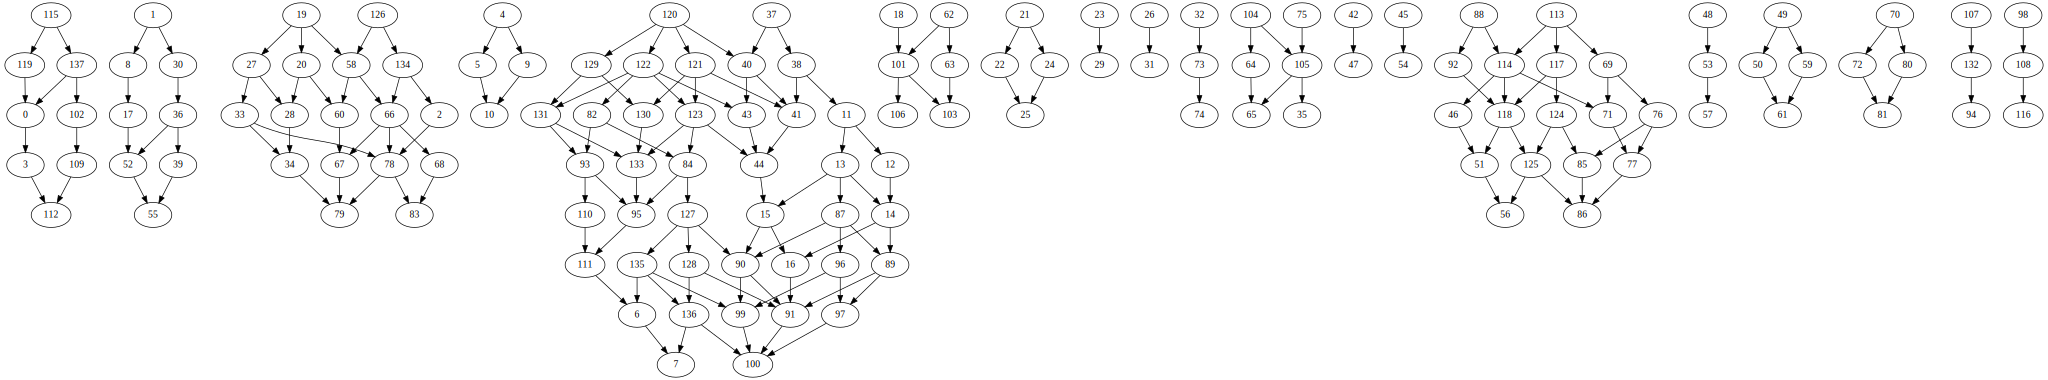

In [13]:
D = DSGRN.Digraph()
D.resize(len(cusp_bistables))
for i in cusp_bistables:
    for j in parameter_graph.adjacencies(i, "codim1"):
        if j in cusp_bistables and i < j:
            D.add_edge(cusp_bistables.index(i),cusp_bistables.index(j))
DSGRN.DrawGraph(D)

While there is the occasional lone cusp bifurcation, it appears there are multiple large connected components of these bistable parameter nodes. First we write a breadth-first search to identify the connected components.

In [14]:
def get_components(D):
    to_check = list(range(D.size()))
    DT = D.transpose()
    components = []
    
    while to_check > []:
        stack = [to_check.pop(0)]
        indices = set()
        while stack > []:
            current = stack.pop(0)
            indices.add(cusp_bistables[current])
            news = D.adjacencies(current) + DT.adjacencies(current)
            for new in news:
                if cusp_bistables[new] not in indices:
                    if new in to_check:
                        to_check.remove(new)
                    stack.append(new)
        components.append(list(indices))
        
    return components

In [15]:
components = get_components(D)

Now that we have the components, we can study continuation between these bistable nodes. Let's look at the first connected component in the list of components.

In [16]:
component = components[0]
print("Component parameter indices:",component)
parameter_complex, stg_dict = full_parameter_complex(parameter_graph, component, 1)
shf = attractor_sheaf(parameter_complex, stg_dict)

Component parameter indices: [2465, 2567, 3467, 2477, 2579, 3479, 2555, 3455]


In [17]:
shf_cohomology = sheaf_cohomology(clean_stalks(shf))
betti = [len(b) for b in shf_cohomology]
print("Betti numbers:",betti)

Betti numbers: [10, 5]


Since the second Betti number is nonzero, we can conclude there must have been a bifurcation between the bistable nodes. The large number of global sections indicates that there are many ways to continue dynamics of the bistable nodes.

# References

[1] Gedeon T, Cummins B, Harker S, Mischaikow K (2018) Identifying robust hysteresis in networks. PLOS Computational Biology 14(4): e1006121.